##### [과제] diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.

- SkinThickness 와 Insulin의 0 값은 상당히 많기 때문에 일괄 삭제가 어려우며 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출
- 산출된 임계값을 적용한 평가
    - ※ 피처 정보 'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압), 'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린), 'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'
- 데이터 세트는 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터임.
-  고립된 지역에서 인디언 고유의 혈통이 지속돼 왔지만 20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생

### 피마 당뇨병 데이터 세트 구성
- Pregnancies : 임신횟수
- Glucose : 포도당 부하 검사 수치
- BloodPressure : 혈압
- SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값
- Insulin : 혈청 인슐린
- BMI : 체질량 지수
- DiabetesPedigreeFunction : 당뇨 내력 가중치 값
- Age : 나이
- Outcome : 당뇨여부(0 또는 1)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [5]:
diabetes_data = pd.read_csv('./dataset/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)
# 전체 768개의 데이터 중에서 Negative 값 0이 500개, Positive 값 1이 268개로 Negative가 상대적으로 많다.

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [17]:
# diabetes 데이터 갼략히 보기(feature type 및 Null 값 개수 보기)
diabetes_data.info()
# Null 값은 존재하지 않으며 모두 int, float의 숫자형 데이터 
# Null 값과 문자열 처리를 위한 별도의 작업은 필요하지 않음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### 로지스틱 회귀를 이용한 예측모델 생성

In [19]:
# 평가지표 출력하는 함수 설정
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [8]:
# Precision_Recall Curve Plot 그리기
def precision_recall_curve_plot(y_test, pred_proba):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    # x축을 threshold, y축을 정밀도, 재현율로 그래프 그리기
    plt.figure(figsize=(8,6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:thresholds_boundary], linestyle='--', label= 'precision')
    plt.plot(thresholds, recalls[:thresholds_boundary], linestyle=':', label='recall')
    
    # threshold의 값 x축의 scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlim()
    plt.xlabel('thresholds')
    plt.ylabel('precision & recall value')
    plt.legend()
    plt.grid()

In [20]:
# 피쳐 데이터 세트 X, 레이블 데이터 세트 y 를 추출
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:,:-1]
y = diabetes_data['Outcome']

# 데이터를 훈련과 테스트 데이터 셋으로 분리
# stratify 분류 모델의 데이터에서 train과 test를 나눌 때, 각각 train과 test가 원래 데이터의 분포와 유사하게 데이터를 추출해 주는 파라미터이다. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬:
 [[88 12]
 [23 31]]

정확도: 0.7727
정밀도: 0.7209
재현율: 0.5741
F1: 0.6392
AUC: 0.7270


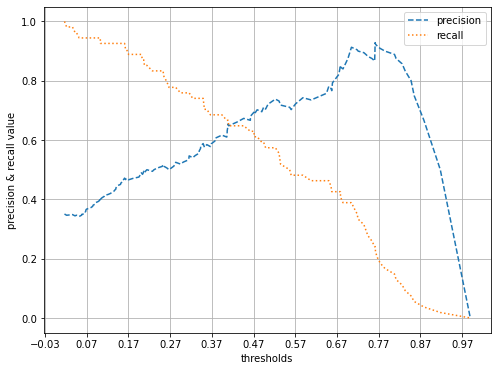

In [21]:
# 임계값별로 정밀도-재현율 출력
pred_proba = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba)
# 위의 정밀도-재현율 그래프를 보면 임계값을 약 0.42 정도로 맞추면 정밀도와 재현율이 균형을 이룰 것으로 보임
# 이 때의 정밀도, 재현율은 0.7이 조금 되지 않는 수준으로 그렇게 높은 것은 아님
# 데이터를 먼저 다시 확인해서 개선할 부분이 있는지 확인

In [22]:
# 데이터의 기초 통계값들
diabetes_data.describe()
# min값이 0으로 되어 있는 값들이 많이 존재함
# Glucose(당 수치), BloodPressure(혈압), SkinThickness(피하지방), Insulin(인슐린), BMI(체질량 지수) 같은 값이 실제로 0일 수는 없다고 생각되므로 확인이 필요

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


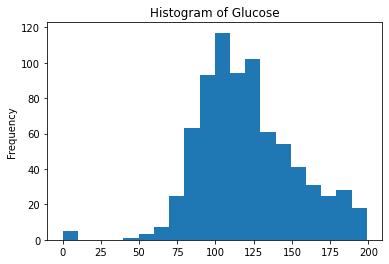

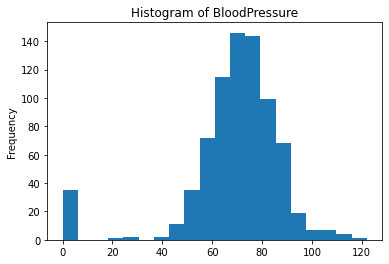

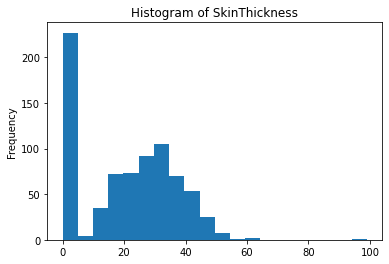

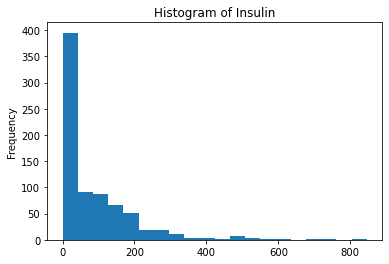

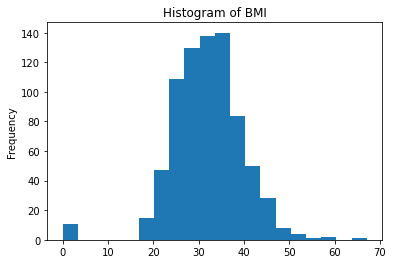

In [23]:
# 확인할 컬럼들 리스트로 선언 -> Pregnancies 임신 횟수이므로 제외
feature_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def hist_plot(df):
    for col in feature_list:
        df[col].plot(kind='hist', bins=20).set_title('Histogram of '+col)
        plt.show()

hist_plot(diabetes_data)

In [24]:
# 위 컬럼들에 대한 0 값의 비율 확인
zero_count = []
zero_percent =[]
for col in feature_list:
    zero_num = diabetes_data[diabetes_data[col]==0].shape[0]
    zero_count.append(zero_num)
    zero_percent.append(np.round(zero_num/diabetes_data.shape[0] * 100, 2))

zero = pd.DataFrame([zero_count, zero_percent], columns = feature_list, index=['count', 'percent']).T
zero


,count,percent
Glucose,5.0,0.65
BloodPressure,35.0,4.56
SkinThickness,227.0,29.56
Insulin,374.0,48.70
BMI,11.0,1.43


In [ ]:
# SkinThickness와 Insulin의 경우 0 값의 비율이 각각 29.56%, 48.70%로 상당히 높음
# 이들 데이터를 삭제하기에는 너무 많으므로 피처 0 값을 평균 값으로 대체
diabetes_data[feature_list]= diabetes_data[feature_list].replace(0, np.nan)

# 위 5개 feature에 대해 0값을 평균 값으로 대체
mean_features = diabetes_data[feature_list].mean()
diabetes_data[feature_list] = diabetes_data[feature_list].replace(np.nan, mean_features)

In [28]:
# 데이터 세트에 대해 피처 스케일링을 적용하여 변환하기(로지스틱 회귀의 경우, 숫자 데이터에 스케일링을 적용하는 것이 일반적으로 성능이 좋음) 
X = diabetes_data.iloc[:, :-1] # 마지막컬럼 제외한 전체
y = diabetes_data.iloc[:, -1] # 마지막컬럼

# StandardScaler 클래스를 상용하여 데이터 세트에 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=156, stratify = y)

# 로지스틱 회귀로 학습, 예측, 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

# 0 값에 대한 처리와 스케일링을 통해 앞선 예측보다는 소폭 개선되었음

오차행렬:
 [[90 10]
 [21 33]]

정확도: 0.7987
정밀도: 0.7674
재현율: 0.6111
F1: 0.6804
AUC: 0.7556


In [29]:
# 평가지표를 조사하기 위한 새로운 함수 생성
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    
    # thresholds list 객체 내의 값을 iteration 하면서 평가 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임계값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)

In [30]:
# 분류 결정 임곗값을 변화시키면서 재현율 값의 성능 수치가 어느 정도나 개선되는지 확인
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임계값:  0.3
오차행렬:
 [[69 31]
 [13 41]]

정확도: 0.7143
정밀도: 0.5694
재현율: 0.7593
F1: 0.6508
AUC: 0.7246

임계값:  0.33
오차행렬:
 [[74 26]
 [17 37]]

정확도: 0.7208
정밀도: 0.5873
재현율: 0.6852
F1: 0.6325
AUC: 0.7126

임계값:  0.36
오차행렬:
 [[76 24]
 [18 36]]

정확도: 0.7273
정밀도: 0.6000
재현율: 0.6667
F1: 0.6316
AUC: 0.7133

임계값:  0.39
오차행렬:
 [[79 21]
 [19 35]]

정확도: 0.7403
정밀도: 0.6250
재현율: 0.6481
F1: 0.6364
AUC: 0.7191

임계값:  0.42
오차행렬:
 [[81 19]
 [20 34]]

정확도: 0.7468
정밀도: 0.6415
재현율: 0.6296
F1: 0.6355
AUC: 0.7198

임계값:  0.45
오차행렬:
 [[85 15]
 [20 34]]

정확도: 0.7727
정밀도: 0.6939
재현율: 0.6296
F1: 0.6602
AUC: 0.7398

임계값:  0.48
오차행렬:
 [[88 12]
 [21 33]]

정확도: 0.7857
정밀도: 0.7333
재현율: 0.6111
F1: 0.6667
AUC: 0.7456

임계값:  0.5
오차행렬:
 [[90 10]
 [21 33]]

정확도: 0.7987
정밀도: 0.7674
재현율: 0.6111
F1: 0.6804
AUC: 0.7556


In [31]:
# 정확도, 정밀도, 재현율, F1, AUC 등의 평가 지표를 보고 적절히 판단하여 임계값을 재 설정하여 예측을 수행할 수 있음

# 임계값을 0.48로 설정하여 예측 수행
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 predict_proba() 예측확률의 array에서 1에 해당하는 컬럼 값을 Binzrizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048)

오차행렬:
 [[88 12]
 [21 33]]

정확도: 0.7857
정밀도: 0.7333
재현율: 0.6111
F1: 0.6667
AUC: 0.7456
